In [2]:
import os

import cv2
import paddle
from PIL import Image
from matplotlib import pyplot

from taiwan_license_plate_recognition.Utils import extract_license_number_paddleocr, extract_license_plate

In [3]:
%load_ext dotenv
%dotenv
%matplotlib inline

In [4]:
paddle.disable_signal_handler()

In [5]:
project_root: str = os.environ.get("PROJECT_ROOT", "")
image_path: str = f"{project_root}/datasets/roboflow/test/images/001509_jpg.rf.d3623b6cb4487f86d0e4ff503f2f234b.jpg"

(-0.5, 639.5, 639.5, -0.5)

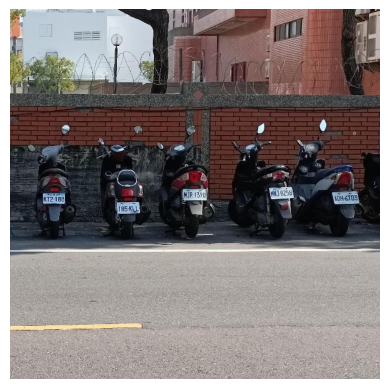

In [7]:
pyplot.imshow(Image.open(image_path))
pyplot.axis("off")

In [8]:
from ultralytics import YOLO

In [9]:
yolo_model = YOLO(f"{project_root}/artifacts/license-plate-detection:v0_openvino_model", task="obb")

In [10]:
results = yolo_model.predict(image_path)

Loading /home/hermeschen/Repo/taiwan-license-plate-recognition/artifacts/license-plate-detection:v0_openvino_model for OpenVINO inference...

image 1/1 /home/hermeschen/Repo/taiwan-license-plate-recognition/datasets/roboflow/test/images/001509_jpg.rf.d3623b6cb4487f86d0e4ff503f2f234b.jpg: 640x640 27.6ms
Speed: 2.9ms preprocess, 27.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [11]:
cropped_images = extract_license_plate(results)

In [12]:
figure = pyplot.figure(figsize=(2, 5))

<Figure size 200x500 with 0 Axes>

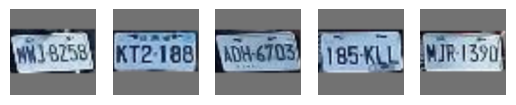

In [13]:
for i in range(len(cropped_images)):
	pyplot.subplot(1, 5, i + 1)
	pyplot.imshow(cropped_images[i])
	pyplot.axis("off")

# EasyOCR

In [14]:
import easyocr

In [15]:
reader = easyocr.Reader(["en"], gpu=False)

[2024-12-13 17:11:39,141] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.


In [16]:
[reader.readtext(image) for image in cropped_images]

[[([[2, 238], [598, 238], [598, 410], [2, 410]],
   '7J9258',
   0.17897376045043012)],
 [([[0, 237], [615, 237], [615, 421], [0, 421]],
   'KT2 /88]',
   0.12473100608423572)],
 [([[26, 191], [640, 191], [640, 436], [26, 436]],
   'Ad4 67037',
   0.047031881474887294)],
 [([[102, 224], [640, 224], [640, 464], [102, 464]],
   '85 KLL',
   0.5871346692408308)],
 [([[22, 230], [606, 230], [606, 412], [22, 412]],
   'MJF |33u1',
   0.1041747361758828)]]

# PaddleOCR

In [17]:
from paddleocr import PaddleOCR

In [18]:
reader = PaddleOCR(lang="en", device="cpu", use_angle_cls=True, max_text_length=8, use_space_char=False, binarize=True)

[2024/12/13 17:11:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/hermeschen/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/hermeschen/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max

In [19]:
extract_license_number_paddleocr(cropped_images, reader)

[2024/12/13 17:11:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08073854446411133
[2024/12/13 17:11:51] ppocr DEBUG: cls num  : 1, elapsed : 0.005560636520385742
[2024/12/13 17:11:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.028154611587524414
[2024/12/13 17:11:51] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04196643829345703
[2024/12/13 17:11:51] ppocr DEBUG: cls num  : 1, elapsed : 0.0019369125366210938
[2024/12/13 17:11:51] ppocr DEBUG: rec_res num  : 1, elapsed : 0.014613151550292969
[2024/12/13 17:11:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.042029619216918945
[2024/12/13 17:11:52] ppocr DEBUG: cls num  : 1, elapsed : 0.0019042491912841797
[2024/12/13 17:11:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.014036893844604492
[2024/12/13 17:11:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04177975654602051
[2024/12/13 17:11:52] ppocr DEBUG: cls num  : 1, elapsed : 0.001920461654663086
[2024/12/13 17:11:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.013996601104736328
[2024/12/

['KT2188', 'ADH6703', '185KLL', 'MJR1390']

# Tesseract

In [20]:
import pytesseract

In [21]:
tesseract_config: str = "--psm 6 --oem 1"

In [22]:
[pytesseract.image_to_string(image, lang="eng", config=tesseract_config) for image in cropped_images]

['WA) 758\n', 'KT2 188]\n', 'it Tost\n', ': 185 KL\n', 'wid\n']

# TrOCR

In [23]:
from optimum.intel import OVModelForVision2Seq
from transformers import TrOCRProcessor

In [24]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed", clean_up_tokenization_spaces=True)

In [25]:
model = OVModelForVision2Seq.from_pretrained(
	"DunnBC22/trocr-base-printed_license_plates_ocr", export=True, device="cpu"
)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [26]:
encode_images = [
	processor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), return_tensors="pt").pixel_values for image in cropped_images
]

In [27]:
generated_ids = [model.generate(image, max_length=8) for image in encode_images]

In [28]:
[processor.batch_decode(ids, skip_special_tokens=True) for ids in generated_ids]

[['MW8258'], ['K21888'], ['AH6705'], ['1855KL'], ['WR1390']]